In [2]:
import matplotlib.pyplot as plt
import matplotlib
import cv2
matplotlib.rc('font', family='sans-serif')
%matplotlib inline
import megengine
import numpy as np

#### 使用`data`和`data.transform(T)`两套API构建CIFAR10数据集

In [3]:
import megengine.data as data
import megengine.data.transform as T

In [4]:
# megengine内置CIFAR10的数据集
dataset = data.dataset.CIFAR10(root="/data", train=True)

# CIFAR10共有10类常见物体
classes = [
    ("plane" , "飞机"),
    ("car"   , "汽车"),
    ("bird"  , "鸟"),
    ("cat"   , "猫"),
    ("deer"  , "鹿"),
    ("dog"   , "狗"),
    ("frog"  , "蛙"),
    ("horse" , "马"),
    ("ship"  , "船"),
    ("truck" , "卡车"),
]

训练数据集的大小: 50000
这张图片的标签是: 7 代表类别 horse 马
(32, 32, 3)


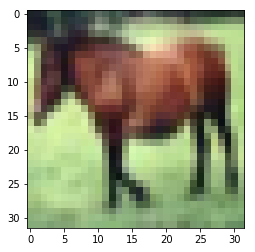

In [31]:
# 训练数据集包括50000组数据
print("训练数据集的大小:", len(dataset))

# 一组数据是一张图片及其类别标签的元组（tuple）
image, label = dataset[7]
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print("这张图片的标签是:", label, "代表类别", *classes[label])

print(image.shape)

In [6]:
print("图片的每个元素都用0-255之间的整数(uint8)表示\n", image[:,:,0])

图片的每个元素都用0-255之间的整数(uint8)表示
 [[ 39  44  47 ...  45  53  47]
 [ 38  41  39 ...  97 101 100]
 [ 42  43  40 ... 143 144 143]
 ...
 [118 118 127 ... 119 112 119]
 [124 129 134 ... 119 119 111]
 [123 124 124 ... 100  99  96]]


In [32]:
# 通过 DataLoader 构建批量的数据生产线
#   生产线的三要素：
#     1. 数据集 dataset
#     2. 采样器 sampler, 采取随机采样策略，每次采 64 个样本，即 batch_size = 64
#     3. 变换器 transform, 对样本图片进行变换，比如增广、归一化和转置
dataloader = data.DataLoader(
    dataset,
    sampler=data.RandomSampler(dataset, batch_size=64, drop_last=True),
    transform=T.Compose([
        T.RandomHorizontalFlip(),
        T.Normalize(mean=0., std=255.),  # f(x) = (x - mean) / std
        T.ToMode("CHW"),  # N,C,H,W
    ])
)

In [34]:
print("dataloader是一个迭代器，其长度为 floor (50000 / 64) =", len(dataloader), "\n")

for batch in dataloader:
    # 每个批次(batch)的数据都是(图片，标签)的二元组
    images, labels = batch
    # 取到第一批数据就跳出循环
    break
    
print("图片的类型是numpy.ndarray, 大小为", images.shape)
print("\n", images[0, 0], "\n")
print("标签的类型也是numpy.ndarray, 大小为", labels.shape)
print("\n", labels)

# 我们将刚才的小马图片保存下来
image_horse = dataloader.transform.apply(image)[np.newaxis,:]
label_horse = np.array([label])

dataloader是一个迭代器，其长度为 floor (50000 / 64) = 781 

图片的类型是numpy.ndarray, 大小为 (64, 3, 32, 32)

 [[0.8666667  0.8509804  0.8627451  ... 0.9098039  0.9019608  0.92941177]
 [0.8352941  0.8235294  0.8352941  ... 0.8901961  0.8901961  0.9098039 ]
 [0.80784315 0.8        0.8117647  ... 0.8901961  0.88235295 0.9098039 ]
 ...
 [0.17254902 0.2        0.21176471 ... 0.23137255 0.19215687 0.18039216]
 [0.10196079 0.09411765 0.09803922 ... 0.24705882 0.19607843 0.1764706 ]
 [0.06666667 0.05490196 0.07843138 ... 0.32156864 0.23137255 0.18039216]] 

标签的类型也是numpy.ndarray, 大小为 (64,)

 [9 7 0 5 4 7 0 2 1 9 1 1 9 6 5 6 6 9 1 9 9 6 0 1 6 7 3 7 9 9 4 5 5 6 1 6 9
 9 2 8 1 6 3 1 2 2 5 8 6 9 4 5 2 0 6 3 2 8 4 7 4 6 1 4]


### 使用`module(M)`和`functional(F)`两套API构建ResNet18的模型

In [9]:
import megengine.module as M
import megengine.functional as F

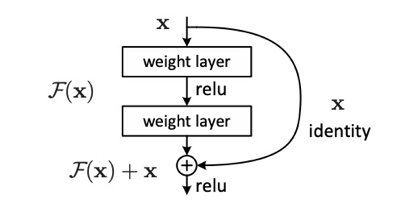

In [35]:
class BasicBlock(M.Module):
    """每个ResNet18的Block都包含两层卷积"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # 第一层卷积，接 BN 和 ReLU
        self.conv1 = M.ConvBnRelu2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=3, stride=stride, padding=1)
        # 第二层卷积，只接 BN
        self.conv2 = M.ConvBn2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, stride=1, padding=1)
        # 残差连接，当输入输出不一致/需要下采样时，用 ConvBn 实现变换
        if in_channels == out_channels and stride == 1:
            self.res_conn = M.Identity()
        else:
            self.res_conn = M.ConvBn2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=1, stride=stride)
    
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + self.res_conn(identity)
        return F.relu(x)

##### 以防有人不知道卷积的stride代表什么（左stride=1，右stride=2）
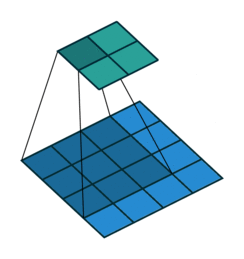
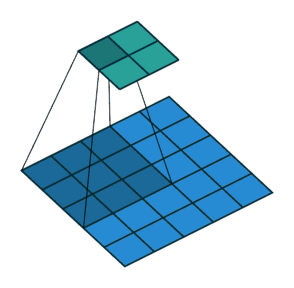

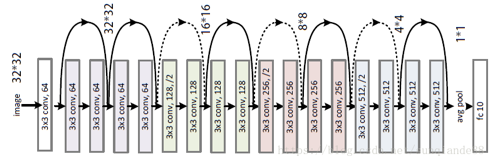

In [36]:
class ResNet18(M.Module):
    def __init__(self):
        self.conv1 = M.ConvBnRelu2d(in_channels=3, out_channels=64,
                                    kernel_size=3, padding=1)
        # 8 个 BasicBlock，3 次下采样(stride=2)，共 8x2=16 层卷积
        self.blocks = M.Sequential(
            BasicBlock(64,  64),
            BasicBlock(64,  64),
            BasicBlock(64,  128, stride=2),
            BasicBlock(128, 128),
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256),
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512),
        )
        # 全连接分类器，输出维度为 10 类的预测
        self.classifier = M.Sequential(
            M.Dropout(0.2),
            M.Linear(512, 10)
        )
    
    def forward(self, x):
        # 1. 特征提取，输入为 Nx3x32x32 的图片，输出为 Nx512x4x4的张量(Tensor)
        x = self.conv1(x)
        x = self.blocks(x)
        # 2. 4x4平均池化(Average Pooling)
        x = F.avg_pool2d(x, 4)
        x = F.flatten(x, 1)
        # 3. 分类预测
        x = self.classifier(x)
        return x

交叉熵损失为: Tensor([3.4053])


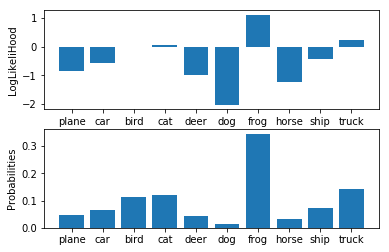

In [37]:
# 构建网络与输入
model = ResNet18()
image = megengine.tensor(image_horse, dtype="float32")
label = megengine.tensor(label_horse, dtype="int32")

# 网络的输出代表分类的对数似然
loglikelihood = model(image)

# 经过softmax得到归一化后的概率分布
probabilities = F.softmax(loglikelihood)

# 计算交叉熵 Cross Entropy 损失函数
loss = F.cross_entropy(probabilities, label)
# 在实际训练中，我们使用数值稳定的交叉熵函数，直接使用对数似然进行计算
loss = F.cross_entropy_with_softmax(loglikelihood, label)

# 将对数似然和概率分布可视化
plt.subplot(2, 1, 1)
plt.bar([c[0] for c in classes], loglikelihood[0])
plt.ylabel("LogLikeliHood")
plt.subplot(2, 1, 2)
plt.bar([c[0] for c in classes], probabilities[0])
plt.ylabel("Probabilities")
print("交叉熵损失为:", loss)

In [38]:
# 构造优化器
import megengine.optimizer as optimizer
opt = optimizer.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

交叉熵损失为: Tensor([0.0028])


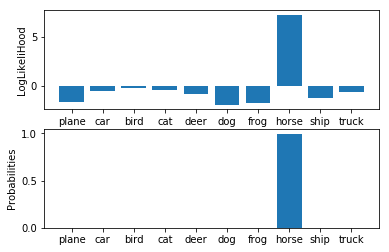

In [40]:
# 使用set_value更新数据（使用小马的图片和标签）
image.set_value(image_horse)
label.set_value(label_horse)

# 网络前传，计算对数似然和交叉熵损失
loglikelihood = model(image)
probabilities = F.softmax(loglikelihood)
loss = F.cross_entropy_with_softmax(loglikelihood, label)

# 优化器进行一次优化
opt.zero_grad()
opt.backward(loss)
opt.step()

# 网络再次前传，计算更新后的网络输出的对数似然和交叉熵损失
loglikelihood = model(image)
probabilities = F.softmax(loglikelihood)
loss = F.cross_entropy_with_softmax(loglikelihood, label)

# 将对数似然和概率分布可视化
plt.subplot(2, 1, 1)
plt.bar([c[0] for c in classes], loglikelihood[0])
plt.ylabel("LogLikeliHood")
plt.subplot(2, 1, 2)
plt.bar([c[0] for c in classes], probabilities[0])
plt.ylabel("Probabilities")
print("交叉熵损失为:", loss)

### 完整的训练

In [14]:
def training():
    # megengine内置CIFAR10的数据集
    dataset = data.dataset.CIFAR10(root="/data", train=True)
    
    # 构造数据生产线
    dataloader = data.DataLoader(
        dataset,
        sampler=data.RandomSampler(dataset, batch_size=64, drop_last=True),
        transform=T.Compose([
            T.RandomHorizontalFlip(),
            T.Normalize(mean=0., std=255.),  # f(x) = (x - mean) / std
            T.ToMode("CHW"),
        ])
    )
    
    # 构造网络与输入
    model = ResNet18()
    image = megengine.tensor(image_horse, dtype="float32")
    label = megengine.tensor(label_horse, dtype="int32")
    
    # 构造网络优化器
    opt = optimizer.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    
    for epoch in range(90):
        # 训练一个epoch == 遍历一次训练数据集
        for i, batch_data in enumerate(dataloader):
            # 进行一次迭代，先更新输入的数据
            image.set_value(batch_data[0])
            label.set_value(batch_data[1])
            
            # 前传
            loglikelihood = model(image)
            loss = F.cross_entropy_with_softmax(loglikelihood, label)
            accuracy = F.accuracy(loglikelihood, label)
            
            # 反传并更新网络参数
            opt.zero_grad()
            opt.backward(loss)
            opt.step()
            print("epoch", epoch, "step", i, "loss", loss, "acc@1", accuracy)